# World Bank Project Clustering - v1.1


*MIT Megacity Logistics Lab*(c): Esteban Mascarino <estmasca@mit.edu>, Daniel Merchan <dmerchan@mit.edu>, Matthias Winkenbach <mwinkenb@mit.edu>

**Summary**: This script reads from the input tables for each city involved in the project (Bogota, Lima and Quito). Those tables summarize the information about population, road network and economic censis at a pixel level for each place. With that data, the code first applies Principal Conponent Analysis (PCA) in order to summarize the information of several numerical variables in a subset of transformed significant variables which explain a certain % of the total variability. Afterwards, by means of K-means we clusters every pixel into a predefined number of groups.

## Scripts

### Loading Modules and Connections

Loading required libraries

In [1]:
# General libraries
from __future__ import division
import numpy as np
import math as m
import pandas as pd
pd.options.display.max_columns = 30
import scipy.linalg
import os

# Specific data science packages
import sklearn.cluster as skcl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.preprocessing import PolynomialFeatures as PolyFeat
from sklearn.preprocessing import StandardScaler as Standardize
from sklearn.preprocessing import scale

from sklearn.model_selection import KFold as KFold
from sklearn.cross_validation import cross_val_score as CV
from sklearn.model_selection import train_test_split as Split
from sklearn.feature_selection import f_regression as RegTest

from wpca import WPCA, EMPCA

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
%matplotlib inline
import seaborn as sns
from IPython.display import Image
from IPython.display import display
import pydotplus

# System libraries
from itertools import combinations
import itertools as it

# Library to convert coordinates from LatLon to UTM
import utm

# Libraries for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Libraries for handling temporal data or monitoring processing time
import datetime as dt
from datetime import datetime, date
import time

#Geospatial packages
from geopandas import GeoDataFrame
from shapely.geometry import Point

#Specific data science packages
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.tree import DecisionTreeRegressor as Reg_Tree
from sklearn.ensemble import RandomForestRegressor as Reg_Forest
from sklearn.ensemble import RandomForestClassifier as Cls_Forest
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS as OLS

from sklearn.preprocessing import PolynomialFeatures as PolyFeat
from sklearn.preprocessing import StandardScaler as Standardize

from sklearn.model_selection import KFold as KFold
from sklearn.model_selection import cross_val_score as CV
from sklearn.model_selection import train_test_split as Split
from sklearn.feature_selection import f_regression as RegTest

from sklearn.decomposition import PCA as PCA
from sklearn.cluster import KMeans as KMeans
from sklearn.cluster import DBSCAN as DBSCAN
import sklearn.cluster as skcl

import statsmodels.api as sm
import statsmodels.formula.api as smf

#Visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.path import Path
import seaborn as sns

#System libraries
from itertools import combinations
import itertools as it

/Users/maggiewilson/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/maggiewilson/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data Uploading

Reads the associated file from the "Input" folder.

In [2]:
def read_file(file_csv):
    """
    Input:
    - file_csv: file path to a .csv file containing all the required information for each pixel.
    
    Output:
    - pixs: data frame of input values.
    """
    
    pixs = pd.read_csv(file_csv, index_col=["pixel_ID"])
    pixs.index.name=None #Needed to remove extra row created when using ID as index
    
    print 'Number of pixels:', len(pixs)
    return pixs

### Data Processing

Filters those pixels that does not reach the minimum population level required and also those that do not have any recorded road infrastructural data.

In [3]:
def filter_pixels_list_pop(pixs, min_pop=1000):
    """
    Inputs:
    - pixs: data frame containing the pixels to be filtered.
    - min_pop: number representing the minimum number of people required in a 1 sq. km pixel.
    
    Output:
    - pixs_output: data frame containing the filtered pixels.
    """
    # Filter by population
    pixs_output = pixs[pixs['population'] >= min_pop]
    
    print 'Number of pixels before filtering:', len(pixs)
    print 'Number of pixels after filtering:', len(pixs_output)
    return pixs_output

In [4]:
def filter_pixels_list_network(pixs, column_name, criteria, below = False):
    """
    Inputs:
    - pixs: data frame containing the pixels to be filtered.
    - column_name: column to be used for filtering
    - citeria: filtering criteria
    - below: if True, function will filter all values below the certain. The default is filter aboive 
    
    Output:
    - pixs_output: data frame containing the filtered pixels.
    """
    # Filter by population
    if below:
        #filter below
        pixs_output = pixs[pixs[column_name] < criteria]
    else:
        #filter above
        pixs_output = pixs[pixs[column_name] > criteria]
    
    print 'Number of pixels before filtering:', len(pixs)
    print 'Number of pixels after filtering:', len(pixs_output)
    return pixs_output

In [5]:
def explore_predictors(pixs, predictors):
    for predictor in predictors:
        print predictor
        sns.distplot(pixs[predictor])
        plt.show()
    return

Removes unnecessary columns from the original data frame.

In [6]:
def remove_columns(input_df,
                   columns_remove = []):
    """
    Inputs:
    - input_df: data frame containing the columns to be removed for PCA.
    - columns_remove: list containing the name of the columns to be removed.
    
    Output:
    - output_df: dataframe ready for PCA with unnecessary columns removed.
    """
    # Clone input_df in order to avoid mutation
    output_df = input_df[:]
    
    # Remove selected columns
    for i in columns_remove:
        del output_df[i]
    
    # Return result
    return output_df

### Data Export

Function for downloading already preprocessed data into specific files.

In [7]:
def save_results(data, file_name='file_name.xlsx', save=True):
    
    """
    Save an Excel file from a dataframe.
    
    Input:
    - data (m x n): Dataframe.
    - file_name: File name.
    - save: Optional to save the data.
    
    Output:
    - Saved file.
    """

    # Save an Excel file named "file_name" in the working directory
    if save:
        data.to_excel(file_name, index=False)
    
    return

### Normalization & PCA

### Weighted PCA

Applies a PCA analysis after normalizing input data and returns the original data frame with the normalized principal components.

Takes the generalized PCA approach based upon the GSVD (Generalized Singular Value Decomposition) described by I.T. Jollife in sections 3.5 and 14.2.1 of Principal Component Analysis 2nd Edition (2002). Michael Greenacre provides further details about the generalized SVD in Apendix A of Theory and Applications of Correspondence Analysis (1984). Both books are available in ".../01 WorldBank shared MLL/04 Bibliography/Weighted PCA/Useful".

The function gsvd(a, m, w) was obtained from: https://github.com/Darwin2011/GSVD.

In [8]:
def gsvd(a, m, w):
    """
    This function defines the generalized version of the SVD which will then be used for calculating a weighted PCA.
    :param a: Matrix to GSVD
    :param m: 1st Constraint, (u.T * m * u) = I
    :param w: 2nd Constraint, (v.T * w * v) = I
    :return: (u ,s, v)
    """

    (aHeight, aWidth) = a.shape
    (mHeight, mWidth) = m.shape
    (wHeight, wWidth) = w.shape

    assert(aHeight == mHeight)
    assert(aWidth == wWidth)

    mSqrt = scipy.linalg.sqrtm(m)
    wSqrt = scipy.linalg.sqrtm(w)


    mSqrtInv = np.linalg.inv(mSqrt)
    wSqrtInv = np.linalg.inv(wSqrt)

    _a = np.dot(np.dot(mSqrt, a), wSqrt)

    (_u, _s, _v) = np.linalg.svd(_a)

    u = np.dot(mSqrtInv, _u)
    v = np.dot(wSqrtInv, _v.T).T
    s = _s

    return (u, s, v)

In [9]:
def gsvd_w_pc_analysis(data_all, exp_var = 95, pixel_identifier = ['index'],
                       obs_weights = None, var_weights = None):
    
    """
    Weighted principal component analysis (based upon the Generalized Single Value
    Decomposition) to transforms the initial set of (correlated) variables 
    into a set of mutually uncorrelated principal components. 
    
    Input:
    - data_all (m x n): Dataframe of data.
    - exp_var: Percentage of the variance to be explained.
    - obs_weights: list of weights for EACH observation in its corresponding order.
                    If None, all observations are equally weighted.
    - var_weights: list of weights for EACH numerical variable in its corresponding order.
                    If None, all numerical variables are equally weighted.
    Output:
    - data_output (m x n): Dataframe including initial data and
                            weighted principal components.
    - n_components_: Number of principal components.
    """
    # Create a copy to avoid mutating the original data frame
    data_all_copy = data_all[:]
    data_all_copy.reset_index(inplace = True)
    
    # Select the columns required for the PCA analysis
    cols_to_use = []
    for i in data_all_copy.columns.tolist():
        if i not in pixel_identifier:
            cols_to_use.append(i)
    data = data_all_copy[cols_to_use]
    
    # Standardize variables by removing the mean and scaling to unit variance
    data_std = Standardize().fit_transform(data)
    
    # Apply the GSVD based upon the selected weights
    if obs_weights != None:
        obs_w = np.diag(np.array(obs_weights))
    else:
        obs_w = np.diag(np.ones(data_std.T.shape[1]))
        
    if var_weights != None:
        var_w = np.diag(np.array(var_weights))
    else:
        var_w = np.diag(np.ones(data_std.T.shape[0]))
    
    u__,s__,v__ = gsvd(data_std.T, var_w, obs_w)
    
    # Generate the pairs of eigenvalues variance and eigenvectors
    eig_pairs = [(np.abs((s__[i]**2)/(data_std.T.shape[1]-1)), u__[:,i]) for i in range(len(s__))]
    eig_pairs.sort()
    eig_pairs.reverse()
    
    # Determine the number of PCs required
    tot_var = np.abs((s__**2)/(len(data)-1)).sum()
    cum_var = 0
    n_components_ = 0
    for i in eig_pairs:
        n_components_ += 1
        cum_var += i[0]
        if cum_var*100/tot_var >= exp_var:
            break
    
    # Generate the transformation matrix
    matrix_w = np.hstack(tuple(eig_pairs[i][1].reshape(len(eig_pairs[i][1]),1) for i in range(n_components_)))
    
    # Transfor the original data with the PCs
    data_shaped = data_std.dot(matrix_w)
    
    print 'Number of principal components:',n_components_
    print 'Explained variance:',round(cum_var*100/tot_var,1),'%'
    
    # Reshape the array and convert to DataFrame
    #data_shaped = data_transf.reshape((len(data),n_components_))
    pcomponents = pd.DataFrame({'Prin'+str(i+1):data_shaped[:,i] for i in range(n_components_)})

    # Concatanate datasets
    frames = [data_all_copy, pcomponents]
    PCAdata = pd.concat(frames,axis=1) 
    
    return PCAdata, n_components_

#### Unweighted PCA

Applies a PCA analysis after normalizing input data and returns the original data frame with the normalized principal components.

In [10]:
def pc_analysis(data_all, exp_var = 95 , pixel_identifier = ['index']):
    
    """
    Principal component analysis to transforms the initial set of (correlated) variables 
    into a set of mutually uncorrelated principal components. 
    
    Input:
    - data_all (m x n): Dataframe of data.
    - exp_var: Percentage of the variance to be explained.
    
    Output:
    - data_output (m x n): Dataframe including initial data and principal components.
    - pca.n_components_: Number of principal components.
    """
    # Create a copy to avoid mutating the original data frame
    data_all_copy = data_all[:]
    data_all_copy.reset_index(inplace = True)
    
    # Select the columns required for the PCA analysis
    cols_to_use = list(set(data_all_copy.columns.tolist())-set(pixel_identifier))
    data = data_all_copy[cols_to_use]
    
    # Standardize variables by removing the mean and scaling to unit variance
    data_std = Standardize().fit_transform(data)
     
    # Select the number of components such that the amount of variance to be explained is greater than the percentage set
    pca = PCA(n_components=float(exp_var)/100., svd_solver = 'full')
   
    # Fit the model and apply the dimensionality reduction
    data_transf = pca.fit_transform(data_std)
    print 'Number of principal components:',pca.n_components_
    print 'Explained variance:',round(np.sum(pca.explained_variance_ratio_).tolist()*100.,1),'%'
    
    # Reshape the array and convert to DataFrame
    data_shaped = data_transf.reshape((len(data),pca.n_components_))
    pcomponents = pd.DataFrame({'Prin'+str(i+1):data_shaped[:,i] for i in range(pca.n_components_)})

    # Concatanate datasets
    frames = [data_all_copy, pcomponents]
    PCAdata = pd.concat(frames,axis=1) 
    
    return PCAdata, pca.n_components_

### K-means Clustering

Returns the optimal number of cluesters applying K-means. This function uses the concept of the F(k) statistic in order to come up with an estimation of that optimal number.

In [11]:
def run_kmeans(x, k):
    """
    K-means clustering analysis
    
    Input:
    - x (m x n): Numpy array with predictors 
    - k: number of clusteres to fit
    
    Output:
    - x_kmeans (m x n): 
    - k_means: Clustering model
    """
    
    print 'K-means clustering for k=', k
    kmeans = KMeans(n_clusters=k, random_state=0).fit(x)
    
    return kmeans.labels_#, k_means

In [12]:
def OptClust(data_all, cols_to_use, minK = 1, maxK = 10, k_add = 2, scaling = False):
    
    """
    Cluster observations that share similar characteriscs using k-means clustering and defining the optimal number of clusters. 
    
    Input:
    - data_all (m x n): Dataframe of data including routes data and principal components.
    - cols_to_use: List with the name of the columns containing the principal components to use for the clustering. 
    - maxK: Maximum number of clusters to be considered. Suggested = 10
    - scaling: Logical value. If True, the clustering data is scaled before clustering. If False, it is not.
    - k_add: integer representing the additional number of clusters to be calculated appart from the optimal number defined by the
                F(k) estimator.
    
    Output:
    - kopt: Optimal number of clusters.
    - ClustersData (m x n): Dataframe including initial data and clusters allocation for k_opt, k_opt+1, ..., k_opt+k_add. 
    """
    
    def Distortion(cluster):
        
        n = len(cluster)
        Nd = len(cluster[0])
        mydist = 0
        center = [np.mean([row[x] for row in cluster]) for x in range(Nd)]
        for i in range(n):
            mydist += (np.linalg.norm(np.array(cluster[i])-np.array(center)))**2
        
        return mydist

    def GiveFk(data, maxK):

        mySk = []
        alpha = [0]
        myFk = [1]
        Nd = len(data[0])
        for k in range(maxK):
            centr, clust_alloc, inert = skcl.k_means(data, k+1, init='k-means++', n_init=100)  #,n_init=1000
            cluster = [] 
            ClustDist = []
            for c in range(k+1):
                cluster.append([data[x] for x in range(len(clust_alloc)) if clust_alloc[x] == c])
                ClustDist.append(Distortion(cluster[c]))
            mySk.append(sum(ClustDist[x] for x in range(k+1)))

            if k>0:
                if k==1:
                    alpha.append(1-(3/(4*Nd)))
                else:
                    alpha.append(alpha[k-1]+((1-alpha[k-1])/6))            

                if mySk[k-1] == 0:
                    myFk.append(1)
                else:
                    myFk.append(mySk[k]/(alpha[k]*mySk[k-1]))

        return myFk
    
    # Select the columns containing the principal components and Route TLP
    
    data = data_all[cols_to_use]
    
    # Standardize the data
    if scaling:
        data = scale(data)
    else:
        data = data.as_matrix()
            
    myF = GiveFk(data, maxK)
    kopt = np.where(myF == min(myF[minK - 1:]))[0][0] + 1
                        
    # Compute optimal clustering
    centr = []
    clust_alloc = []
    inert = []
    centr_new, clust_alloc_new, inert_new = skcl.k_means(data, kopt, init='k-means++', n_init=100)  
    centr.append(centr_new)
    clust_alloc.append(clust_alloc_new)
    inert.append(inert_new)
    
    # Compute addditional clusterings
    for x in range(1,k_add+1):
        centr_new, clust_alloc_new, inert_new = skcl.k_means(data, kopt+x, init='k-means++', n_init=100)  
        centr.append(centr_new)
        clust_alloc.append(clust_alloc_new)
        inert.append(inert_new)
    
    # Create dataframe and concatenate datasets
    kmeans = pd.DataFrame({'kopt+'+str(i)+'_Clusters':clust_alloc[i][:] for i in range(k_add+1)})
    frames = [data_all, kmeans]    
    ClustersData = pd.concat(frames,axis=1)
    
    print 'Optimal number of clusters:',kopt
    return kopt, ClustersData

### Plotting Functions

Plots the associated radar for the centroids charts based on the selected variables to show.

In [13]:
def calculate_centroids(data, cols_clusters, cols_to_delete = ['index']):
    """
    Input:
    - data: data frame containing all the clusters generated with K-means.
    - cols_clusters: list of columns containing the clusters numbers
    - cols_to_delete: list of columns to exclude from the analysis
    
    Output:
    - output_df: data frame containig the centroids for each cluster and clustering option
    """
    # List of columns from which to calculate the centroid
    cols_to_use = list(set(data.columns.tolist())-set(cols_clusters)-set(cols_to_delete))
    
    # Create output DF
    output_df = pd.DataFrame(columns=['number_of_clusters','cluster_id']+cols_to_use)
    for i in cols_clusters:
        df_to_concat = pd.pivot_table(data[cols_to_use+[i]],
                                        index=[i], aggfunc=np.mean)
        df_to_concat['cluster_id'] = df_to_concat.index
        df_to_concat.reset_index(drop=True)
        df_to_concat['number_of_clusters'] = df_to_concat.cluster_id.max()+1
        df_to_concat = df_to_concat[['number_of_clusters','cluster_id']+cols_to_use]
        output_df = pd.concat([output_df, df_to_concat], axis=0)
    
    output_df.reset_index(drop=True)
    
    # Return result
    return output_df

In [75]:
def radar_chart(data, num_of_clusters_field, cluster_id_field, to_plot_fields, labels, city_name, save=True):
    
    """
    Create a radar chart for each cluster displaying the standardized variables values.
    
    Input:
    - df (m x n): Dataframe of data to be displayed.
    - num_of_clusters_field: string containing the name of the column describing the
                                number of groups of clusters
    - cluster_id_field: string containing the name of the field with the clusters ID per
                        group
    - to_plot_fields: list column names containing the variables to be plotted in the radar chart
    - labels: list of names to be plotted for each variable. It should be in the same order as the previous list.
    - city_name: string containing the name of the city for the graphs.
    - save: If True, the radar charts are saved. If False, not.
    
    Output:
    - radar charts which are saved as .png files (one for centroid)
    """
    colors = ['#BAB0AC', '#2bbc23', '#a6c1ed', '#f98e02', '#9f22d8', '#f2d709', '#ff0000']
    def _radar_factory(num_vars):
    
        theta = 2*np.pi * np.linspace(0, 1-1./num_vars, num_vars)
        theta += np.pi/2

        def unit_poly_verts(theta):
            x0, y0, r = [0.5] * 3
            verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
            return verts

        class RadarAxes(PolarAxes):
            name = 'radar'
            RESOLUTION = 1

            def fill(self, *args, **kwargs):
                closed = kwargs.pop('closed', True)
                return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

            def plot(self, *args, **kwargs):
                lines = super(RadarAxes, self).plot(*args, **kwargs)
                for line in lines:
                    self._close_line(line)

            def _close_line(self, line):
                x, y = line.get_data()
                if x[0] != x[-1]:
                    x = np.concatenate((x, [x[0]]))
                    y = np.concatenate((y, [y[0]]))
                    line.set_data(x, y)

            def set_varlabels(self, labels):
                self.set_thetagrids(theta * 180/np.pi, labels)

            def _gen_axes_patch(self):
                verts = unit_poly_verts(theta)
                return plt.Polygon(verts, closed=True, edgecolor='k')

            def _gen_axes_spines(self):
                spine_type = 'circle'
                verts = unit_poly_verts(theta)
                verts.append(verts[0])
                path = Path(verts)
                spine = Spine(self, spine_type, path)
                spine.set_transform(self.transAxes)
                return {'polar': spine}

        register_projection(RadarAxes)

        return theta
    
    def radar_graph(labels = [], values = [], cluster=0, tot_clusters=1, save=True):
         
        N = len(labels) 
        theta = _radar_factory(N)
        #max_val = max(max(optimum), max(values))

        # Define chart characteristics
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='radar')
        ax.set_ylim(0,1)
        ax.set_yticks(np.arange(0,1,0.2))
        ax.plot(theta, values, color=colors[cluster])
        ax.set_title('Radar-Cluster '+str(int(cluster))+' of '+str(int(tot_clusters)), weight='bold', size='large')
        #ax.plot(theta, optimum, color='r')
        ax.set_varlabels(labels)
        #plt.show()

        # Save the radar chart in the working directory
        if save:
            plt.savefig('Output/'+city_name+'/'+str(int(cluster))+' of '+str(int(tot_clusters))+' radar-cluster.png',
                        dpi=360)
            
        return

    data_pre_copy = data[[num_of_clusters_field,cluster_id_field]+to_plot_fields]
    
    # Iterate for each group of clusters
    for k in data_pre_copy[num_of_clusters_field].unique():
        # Normalize clustering centroids
        data_copy = data_pre_copy[(data_pre_copy[num_of_clusters_field] == k)]
        del data_copy[num_of_clusters_field]
        data_copy = data_copy.set_index(cluster_id_field)
        clusters = data_copy.index.tolist()
        for j in data_copy.columns.tolist():
            mini = data_copy[j].min()
            maxi = data_copy[j].max()
            data_copy[j] = (data_copy[j] - mini) / (maxi - mini)
    
    
        for i in clusters:    
            values = data_copy.loc[i].tolist()
            print "Cluster", str(i)
            radar_graph(labels, values, i, k)    
    
    return

In [15]:
def plot_map(df, category_column):
    geo_point = [Point(xy) for xy in zip(df.lon, df.lat)]
    df = df.drop(['lon', 'lat'], axis=1)
    crs = {'init': 'epsg:4326'}
    geo_df = GeoDataFrame(df, crs=crs, geometry=geo_point)
    geo_df.plot(column = category_column, cmap = 'Paired', marker = 's', markersize=15)
    return

## Methodology Execution

### Reading input file from the city and preparing data

The user must supply the name of the city from which to perform the analysis based upon the following abreviations:
 - 'BOG': Bogota
 - 'LIM': Lima
 - 'UIO': Quito

In [16]:
city_name = input('Please provide the abreviation for the city to analyze (write it between ''): ')

Please provide the abreviation for the city to analyze (write it between ): 'LIM'


The code will automatically upload the required file.

In [17]:
pixels_data = read_file('Input/'+city_name+'/'+city_name+'_pixels_population_roadsext_cf_ec.csv')

Number of pixels: 4290


In [40]:
predictors = ['population',
              'count_intersections',
              'streets_per_node_avg',
              'betweenness_centrality_avg',
              'closeness_centrality_avg',
              'primary_length_total_ext',
              'highway_length_total_ext',
              'fraction_oneway_ext',
              'clustering_coefficient_avg',
              'N_Est_Mfg',
              'N_Est_BFA',
              'N_Est_RW',
              'N_Emp_Mfg',
              'N_Emp_BFA',
              'N_Emp_RW','N_Emp_Tot', 'POI_Count']

population


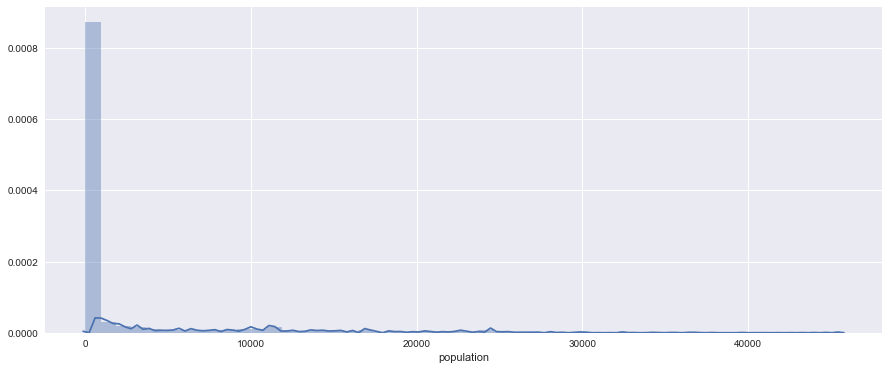

count_intersections


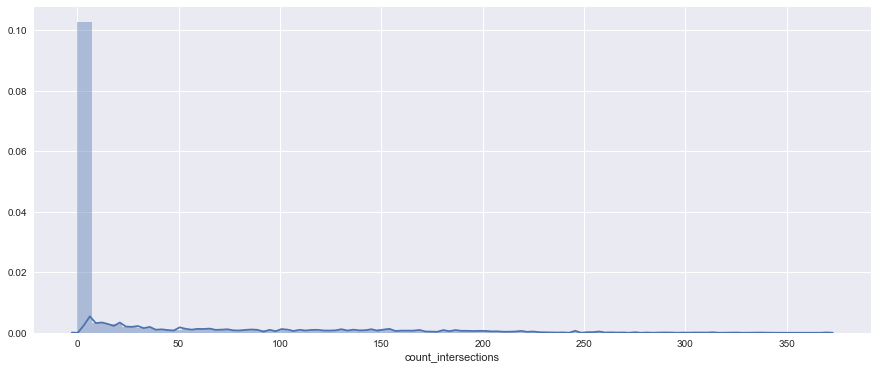

streets_per_node_avg


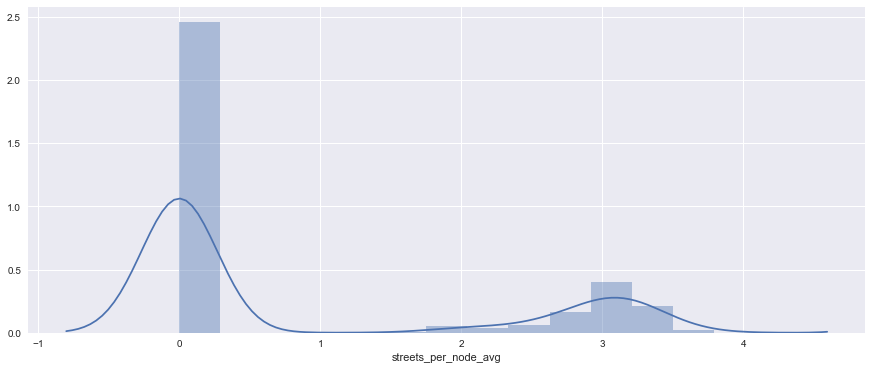

betweenness_centrality_avg


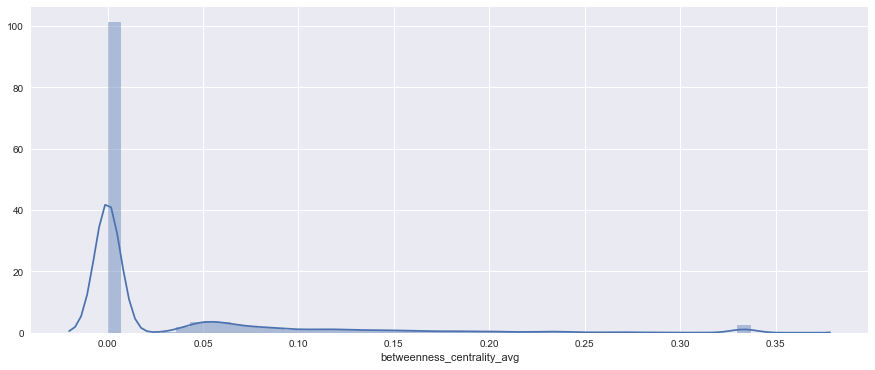

closeness_centrality_avg


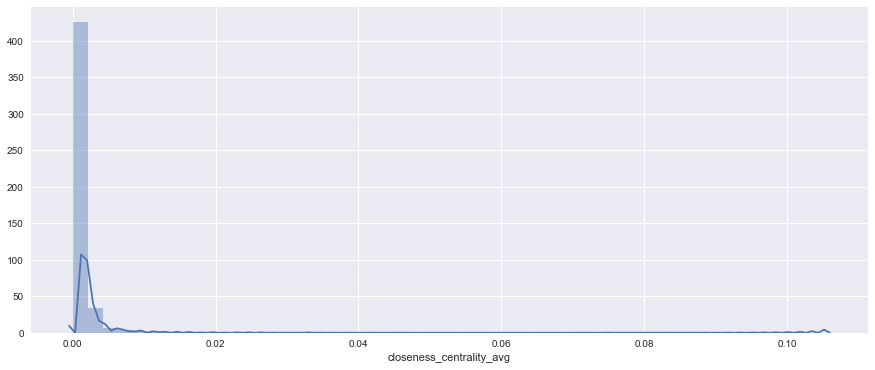

primary_length_total_ext


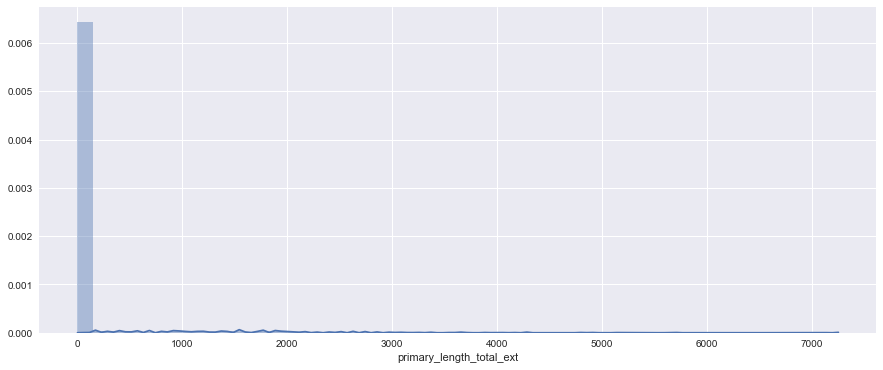

highway_length_total_ext


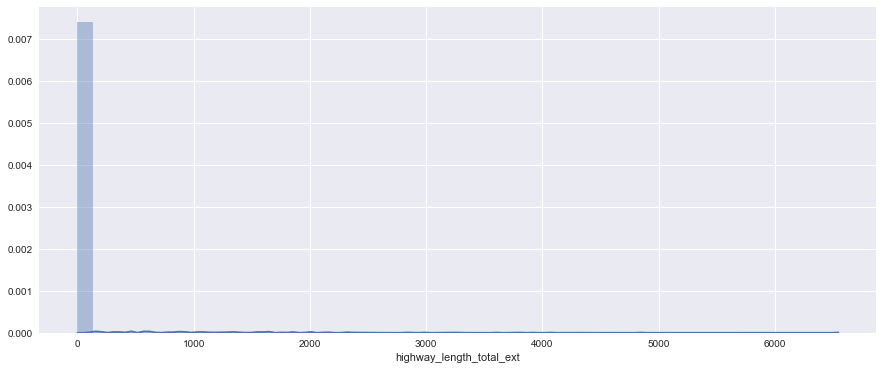

fraction_oneway_ext


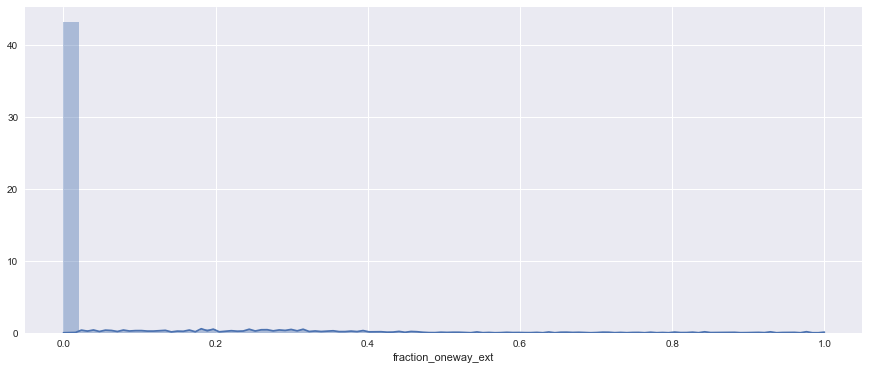

clustering_coefficient_avg


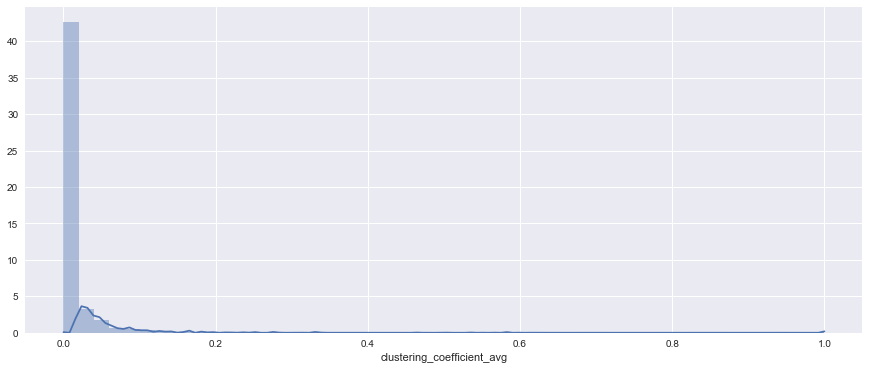

N_Est_Mfg


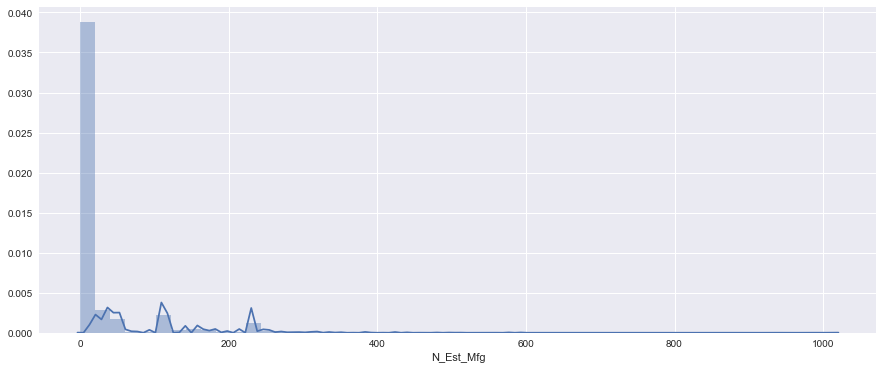

N_Est_BFA


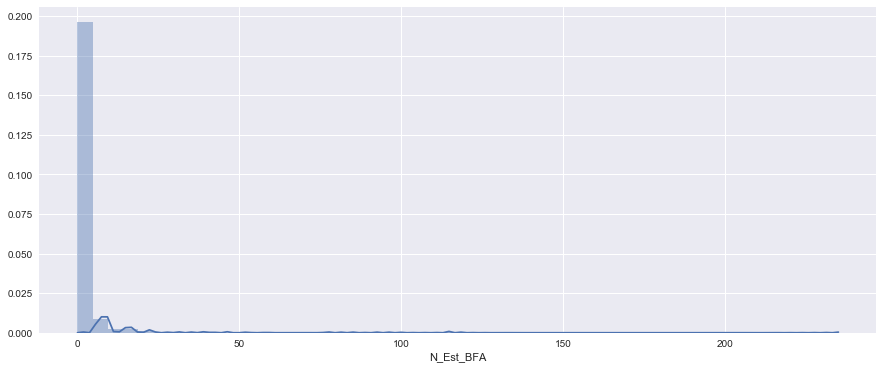

N_Est_RW


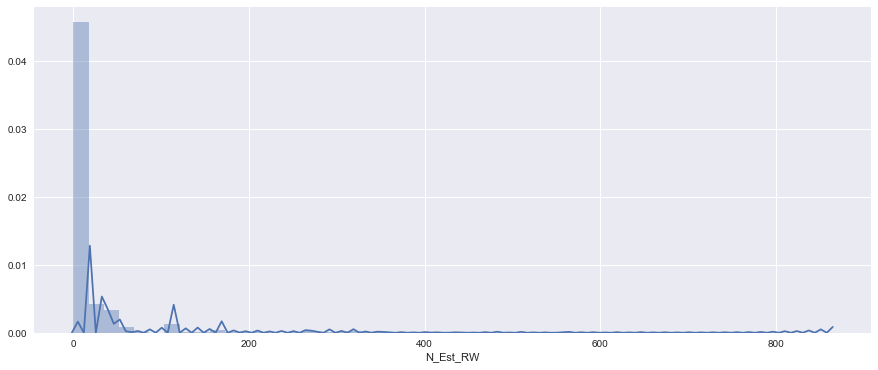

N_Emp_Mfg


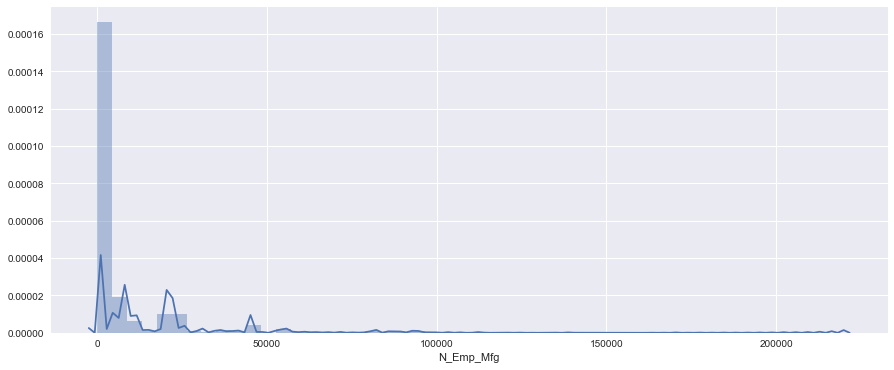

N_Emp_BFA


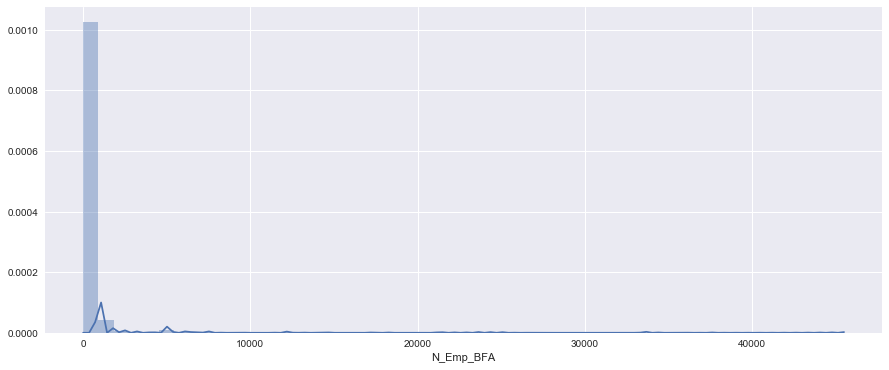

N_Emp_RW


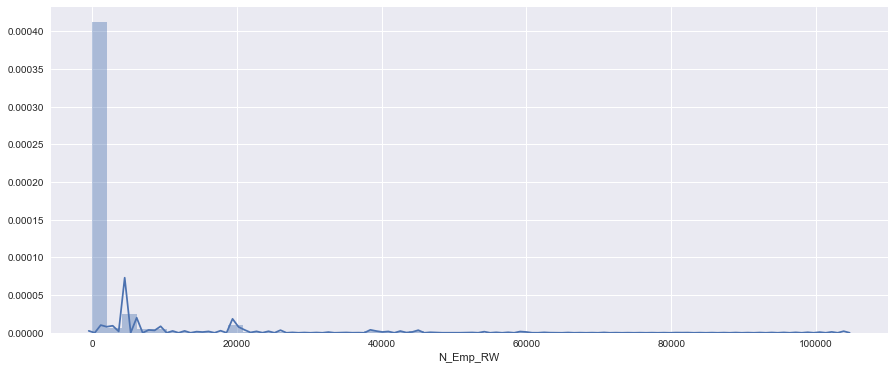

N_Emp_Tot


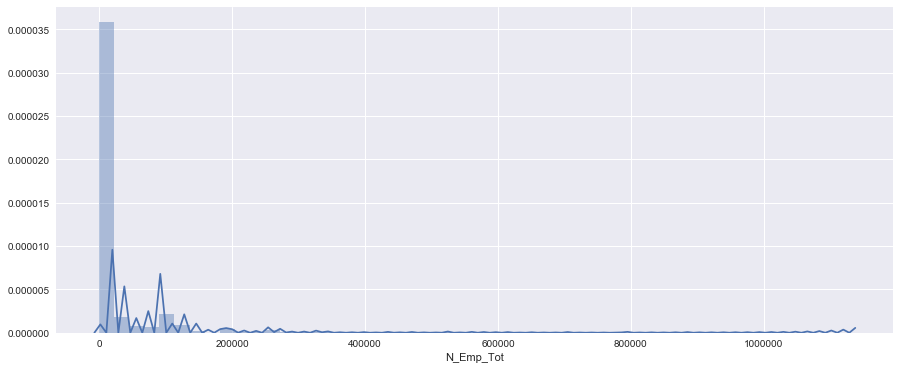

POI_Count


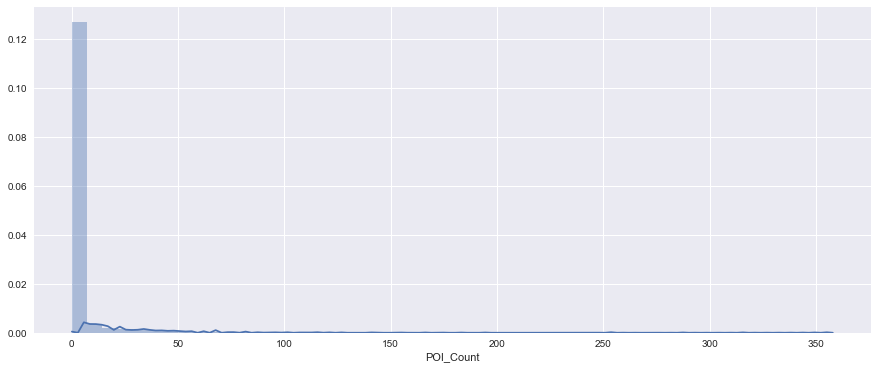

In [41]:
explore_predictors(pixels_data, predictors)

Data is filtered for population and road network.

In [42]:
pixels_data_filtered = filter_pixels_list_pop(pixels_data, min_pop = 1000)

Number of pixels before filtering: 4290
Number of pixels after filtering: 864


In [43]:
pixels_data_filtered = filter_pixels_list_network(pixels_data_filtered,
                                                  'clustering_coefficient_avg', 0)

Number of pixels before filtering: 864
Number of pixels after filtering: 663


In [44]:
pixels_data_filtered = filter_pixels_list_network(pixels_data_filtered,
                                                  'clustering_coefficient_avg', 0.2,
                                                  below= True)

Number of pixels before filtering: 663
Number of pixels after filtering: 654


In [45]:
pixels_data_filtered = filter_pixels_list_network(pixels_data_filtered,
                                                  'betweenness_centrality_avg', 0.25,
                                                  below = True)

Number of pixels before filtering: 654
Number of pixels after filtering: 654


In [46]:
pixels_data_filtered = filter_pixels_list_network(pixels_data_filtered,
                                                  'betweenness_centrality_avg', 0.02)

Number of pixels before filtering: 654
Number of pixels after filtering: 653


In [47]:
pixels_data_filtered = filter_pixels_list_network(pixels_data_filtered,
                                                  'streets_per_node_avg', 0.99)

Number of pixels before filtering: 653
Number of pixels after filtering: 653


In [48]:
pixels_data_filtered = filter_pixels_list_network(pixels_data_filtered,
                                                  'closeness_centrality_avg', 0.005,
                                                 below = True)

Number of pixels before filtering: 653
Number of pixels after filtering: 652


population


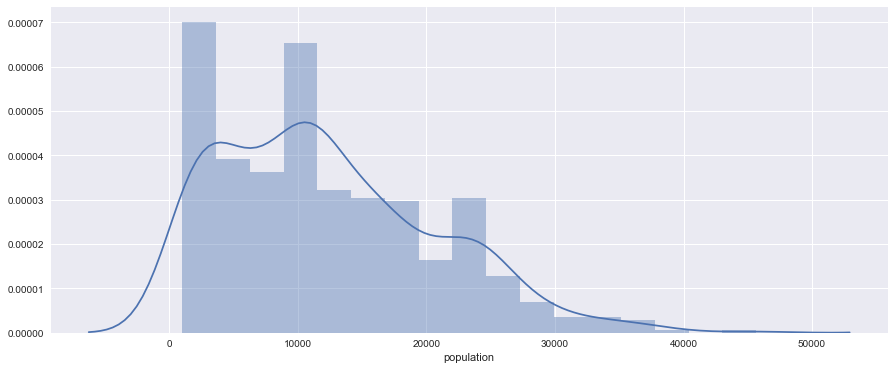

count_intersections


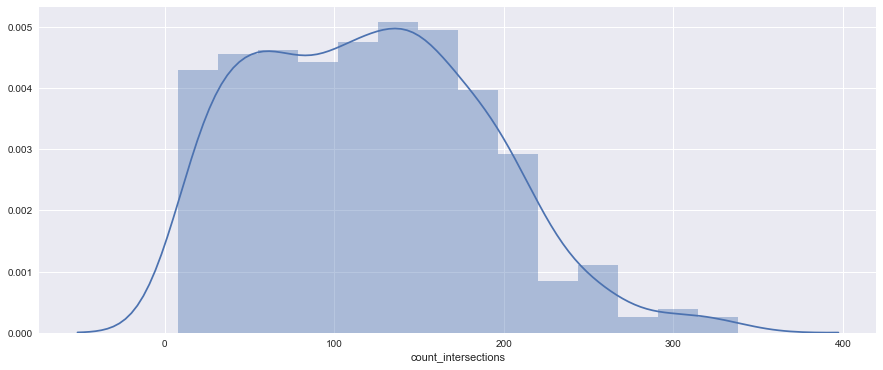

streets_per_node_avg


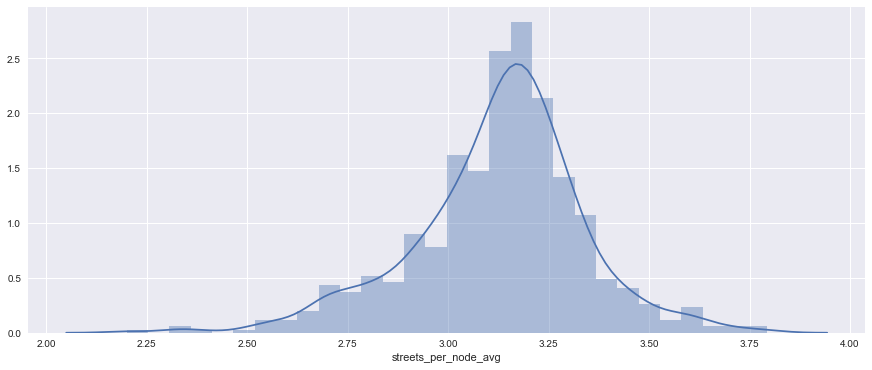

betweenness_centrality_avg


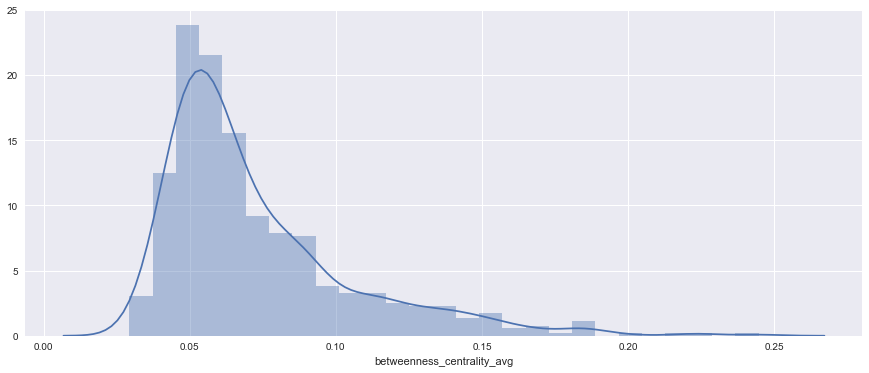

closeness_centrality_avg


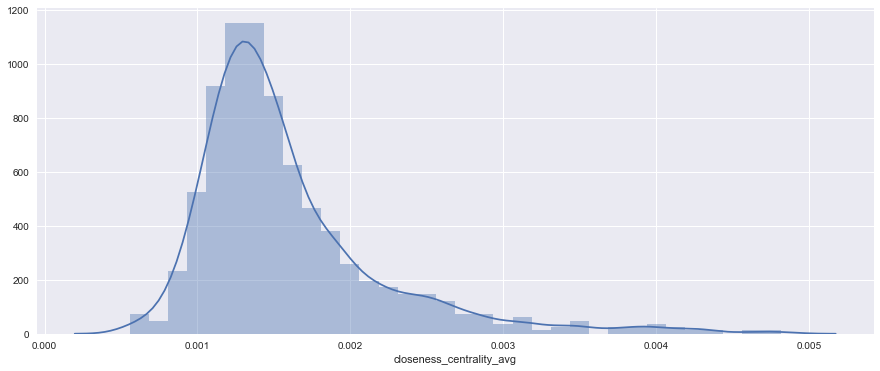

primary_length_total_ext


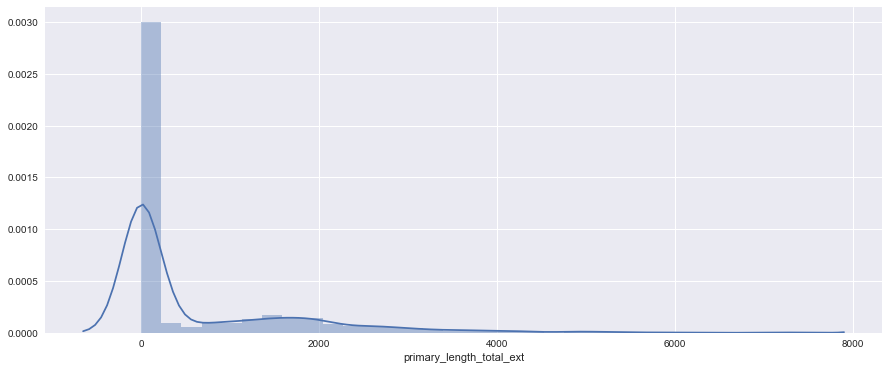

highway_length_total_ext


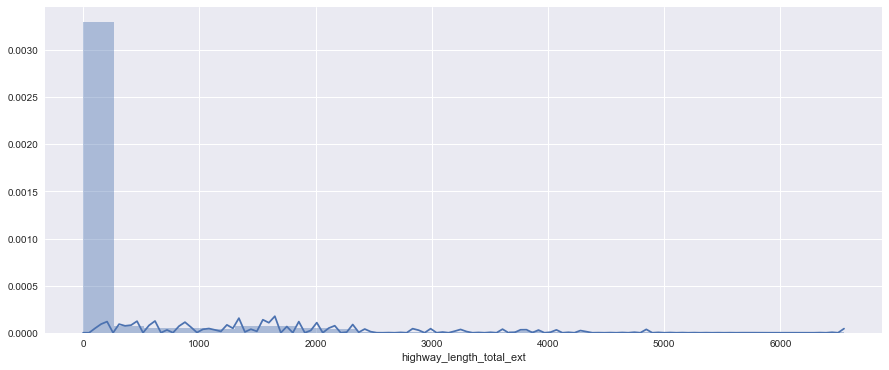

fraction_oneway_ext


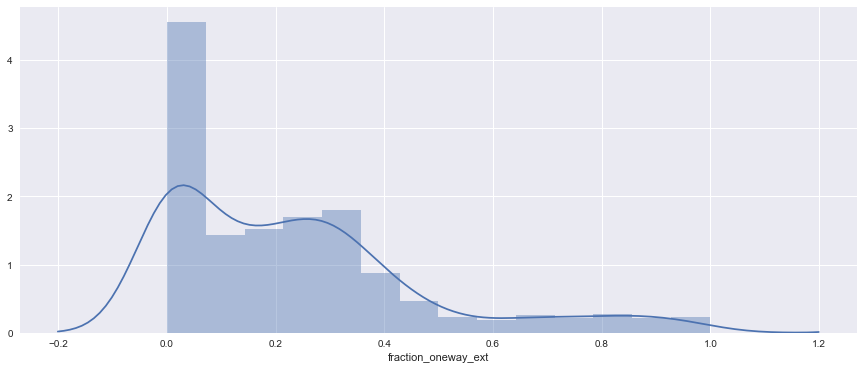

clustering_coefficient_avg


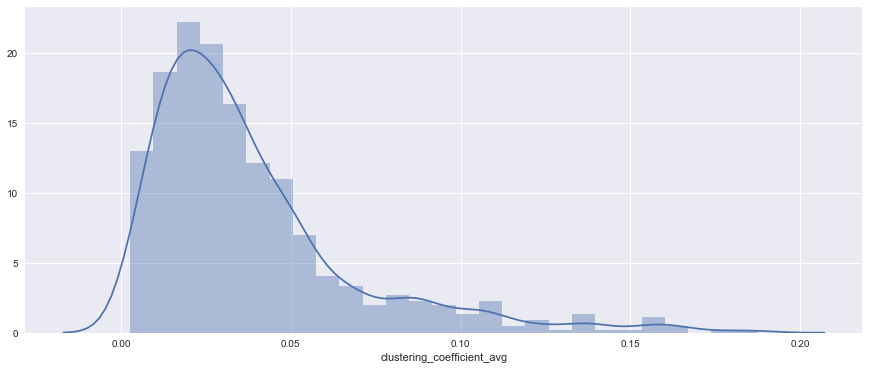

N_Est_Mfg


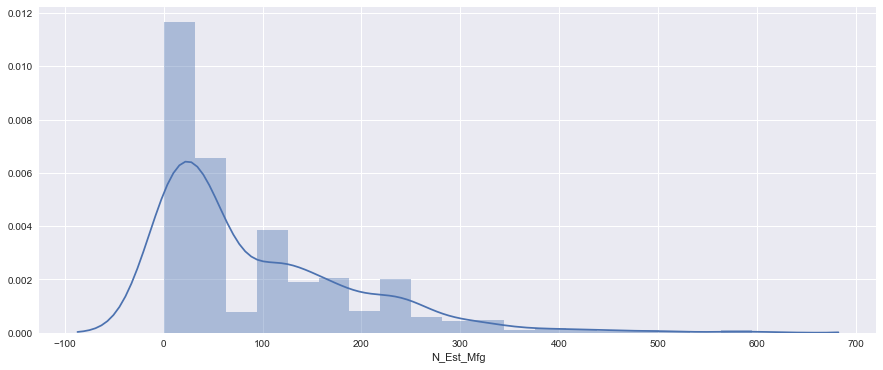

N_Est_BFA


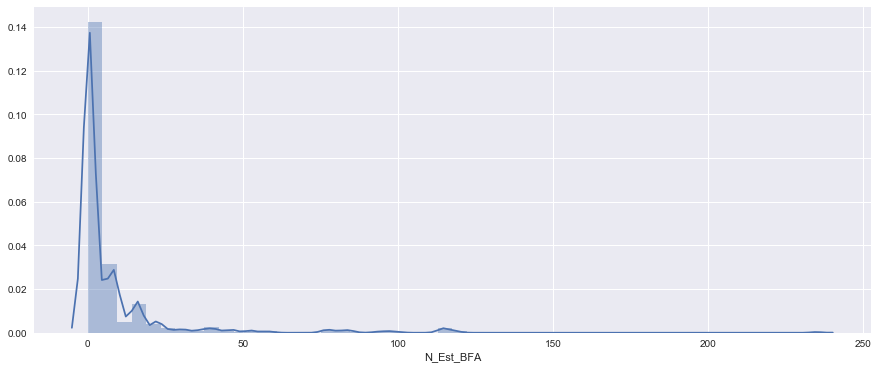

N_Est_RW


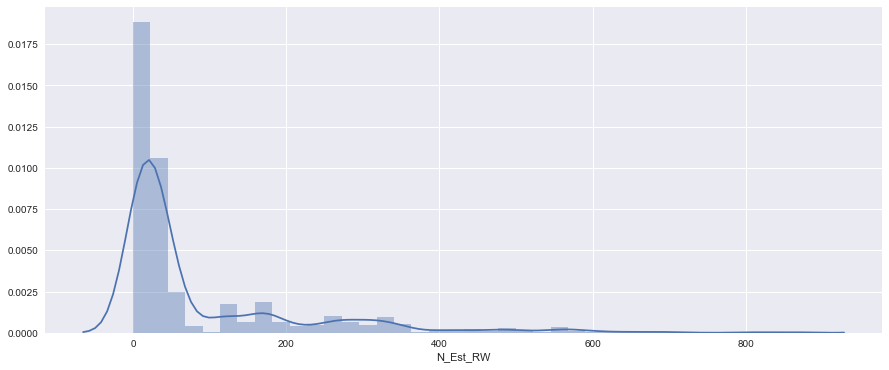

N_Emp_Mfg


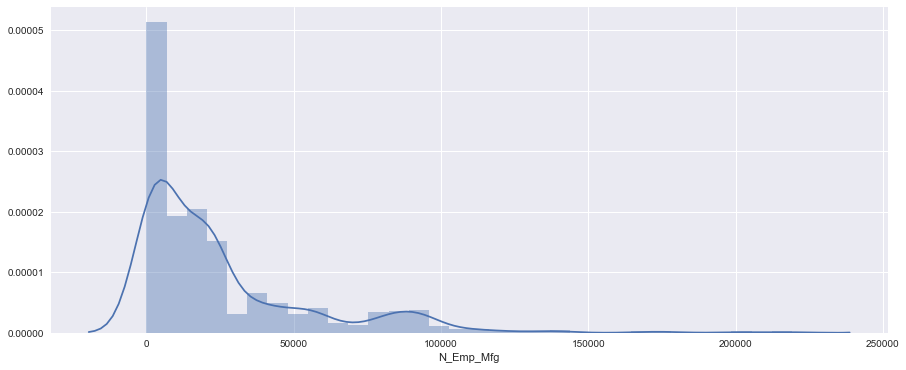

N_Emp_BFA


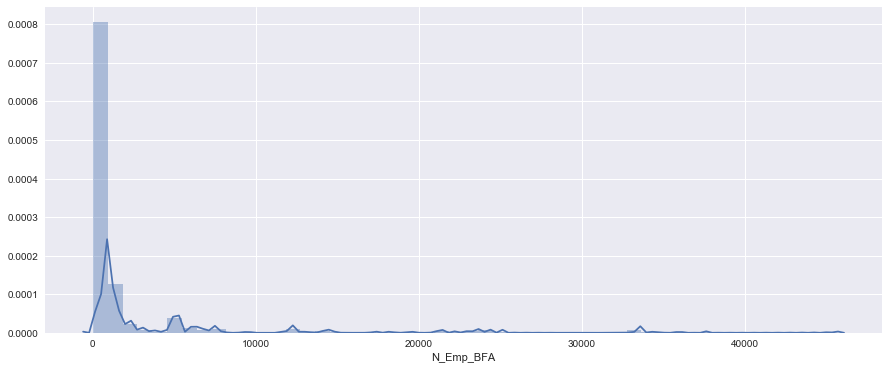

N_Emp_RW


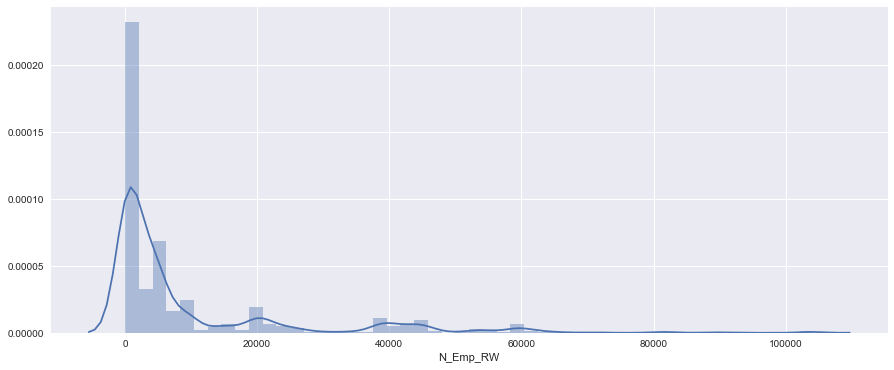

N_Emp_Tot


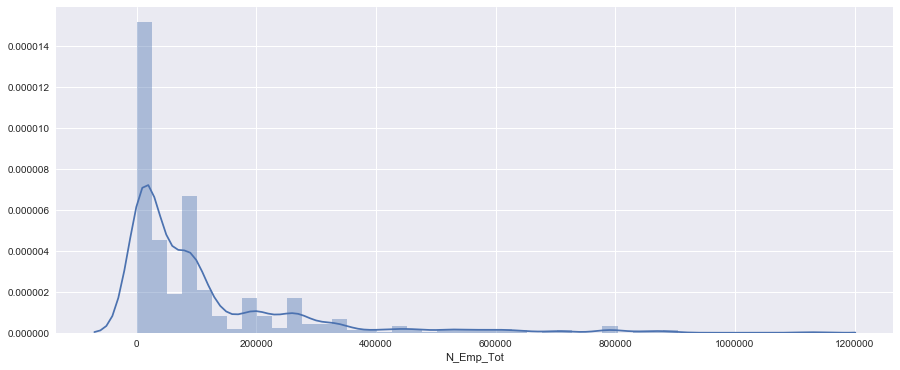

POI_Count


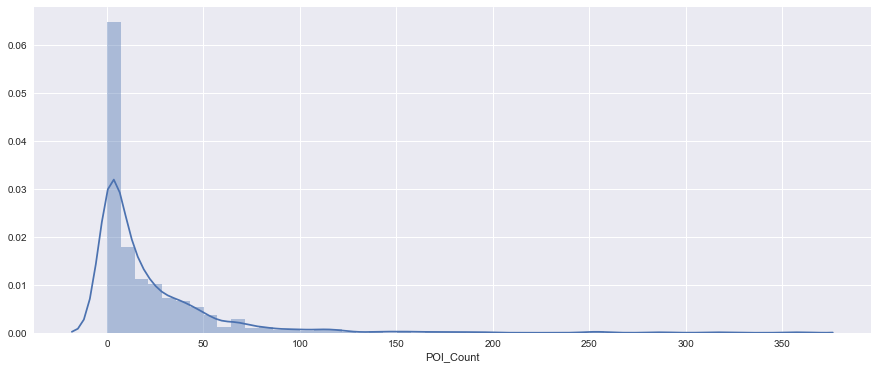

In [49]:
explore_predictors(pixels_data_filtered, predictors)

In [50]:
pixels_data_filtered_ready = pixels_data_filtered[predictors]

pixels_data_filtered_ready = remove_columns(pixels_data_filtered_ready, columns_remove =
                                           ['closeness_centrality_avg',
                                            'clustering_coefficient_avg'])

In [51]:
pixels_data_filtered_ready

,population,count_intersections,streets_per_node_avg,betweenness_centrality_avg,primary_length_total_ext,highway_length_total_ext,fraction_oneway_ext,N_Est_Mfg,N_Est_BFA,N_Est_RW,N_Emp_Mfg,N_Emp_BFA,N_Emp_RW,N_Emp_Tot,POI_Count
117,1461,114,3.041322,0.059484,0.000000,0.000000,0.164404,0.0,1.0,0.0,0.0,1.0,4.0,332.0,38
248,3558,57,3.030769,0.096963,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,4.0,332.0,48
312,1768,63,3.260870,0.076863,0.000000,0.000000,0.061655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
313,6137,96,3.140000,0.091784,0.000000,4060.184994,0.226727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
378,8452,145,3.278912,0.060882,0.000000,0.000000,0.184630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23
443,1416,23,3.521739,0.131752,0.000000,0.000000,0.351102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
444,1963,30,3.027778,0.118371,0.000000,0.000000,0.039808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
508,10039,66,3.185714,0.084119,0.000000,0.000000,0.452238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35
574,4149,9,2.200000,0.186813,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
575,1870,42,2.722222,0.109391,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Running PCA

Running weighted PCA with the cleaned data and at least 90% of explanatory power. Assigning weight of 20% to population, 30% to infrastructure variables, and 50% to socioeconomic variables.

In [55]:
pca_data, n_components = gsvd_w_pc_analysis(pixels_data_filtered_ready, exp_var=90, var_weights = [1/5,    1/20,1/20,1/20,1/20,1/20,1/20,    1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16])

Number of principal components: 7
Explained variance: 93.0 %


In [56]:
pca_data

,index,population,count_intersections,streets_per_node_avg,betweenness_centrality_avg,primary_length_total_ext,highway_length_total_ext,fraction_oneway_ext,N_Est_Mfg,N_Est_BFA,N_Est_RW,N_Emp_Mfg,N_Emp_BFA,N_Emp_RW,N_Emp_Tot,POI_Count,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6,Prin7
0,117,1461,114,3.041322,0.059484,0.000000,0.000000,0.164404,0.0,1.0,0.0,0.0,1.0,4.0,332.0,38,7.114727,1.648241,-0.716472,-1.662589,1.690011,1.488966,0.175915
1,248,3558,57,3.030769,0.096963,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,4.0,332.0,48,8.239472,-0.497781,4.218135,-3.305417,1.012448,0.217245,-0.444929
2,312,1768,63,3.260870,0.076863,0.000000,0.000000,0.061655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,8.235277,0.127473,0.727412,-1.628162,1.708633,2.378518,-1.185460
3,313,6137,96,3.140000,0.091784,0.000000,4060.184994,0.226727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,5.607381,-0.857567,-2.838239,-5.324318,-21.805404,8.777023,5.298749
4,378,8452,145,3.278912,0.060882,0.000000,0.000000,0.184630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,5.813062,4.105240,-2.443006,-1.055450,2.258324,2.950110,-1.207996
5,443,1416,23,3.521739,0.131752,0.000000,0.000000,0.351102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,7.220447,-0.976269,3.855626,-7.584883,1.314609,2.985858,-5.452076
6,444,1963,30,3.027778,0.118371,0.000000,0.000000,0.039808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9.778128,-2.953580,6.690823,-2.168602,0.573109,0.846566,0.330949
7,508,10039,66,3.185714,0.084119,0.000000,0.000000,0.452238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,5.160865,2.633752,2.603606,-5.491300,0.870054,2.333111,-2.635874
8,574,4149,9,2.200000,0.186813,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,13.047463,-8.727022,19.133299,-0.429795,-2.138990,-3.293593,7.022550
9,575,1870,42,2.722222,0.109391,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10.640185,-3.735674,8.036214,0.167269,0.042020,-0.175620,3.443778


### Running K-Means clustering

Running K-Means clustering for the summarized data.

In [57]:
kopt, ClustersData = OptClust(pca_data,
                              ['Prin'+str(i) for i in range(1,n_components+1)], minK=6)

Optimal number of clusters: 7


In [58]:
ClustersData

,index,population,count_intersections,streets_per_node_avg,betweenness_centrality_avg,primary_length_total_ext,highway_length_total_ext,fraction_oneway_ext,N_Est_Mfg,N_Est_BFA,N_Est_RW,N_Emp_Mfg,N_Emp_BFA,N_Emp_RW,N_Emp_Tot,POI_Count,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6,Prin7,kopt+0_Clusters,kopt+1_Clusters,kopt+2_Clusters
0,117,1461,114,3.041322,0.059484,0.000000,0.000000,0.164404,0.0,1.0,0.0,0.0,1.0,4.0,332.0,38,7.114727,1.648241,-0.716472,-1.662589,1.690011,1.488966,0.175915,2,5,5
1,248,3558,57,3.030769,0.096963,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,4.0,332.0,48,8.239472,-0.497781,4.218135,-3.305417,1.012448,0.217245,-0.444929,0,5,5
2,312,1768,63,3.260870,0.076863,0.000000,0.000000,0.061655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,8.235277,0.127473,0.727412,-1.628162,1.708633,2.378518,-1.185460,2,5,5
3,313,6137,96,3.140000,0.091784,0.000000,4060.184994,0.226727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,5.607381,-0.857567,-2.838239,-5.324318,-21.805404,8.777023,5.298749,6,6,8
4,378,8452,145,3.278912,0.060882,0.000000,0.000000,0.184630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,5.813062,4.105240,-2.443006,-1.055450,2.258324,2.950110,-1.207996,2,1,4
5,443,1416,23,3.521739,0.131752,0.000000,0.000000,0.351102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,7.220447,-0.976269,3.855626,-7.584883,1.314609,2.985858,-5.452076,0,5,5
6,444,1963,30,3.027778,0.118371,0.000000,0.000000,0.039808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9.778128,-2.953580,6.690823,-2.168602,0.573109,0.846566,0.330949,0,2,2
7,508,10039,66,3.185714,0.084119,0.000000,0.000000,0.452238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,5.160865,2.633752,2.603606,-5.491300,0.870054,2.333111,-2.635874,2,5,5
8,574,4149,9,2.200000,0.186813,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,13.047463,-8.727022,19.133299,-0.429795,-2.138990,-3.293593,7.022550,0,2,2
9,575,1870,42,2.722222,0.109391,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10.640185,-3.735674,8.036214,0.167269,0.042020,-0.175620,3.443778,0,2,2


Calculating centroids using the mean of each numeric component. Input those columns containing the number of clusters to be plotted and those columns containing data that does not want to be considered, i.e.: the PCA's columns.

In [59]:
centroids = calculate_centroids(ClustersData,
                                ['kopt+0_Clusters'],
                                ['index']+['Prin'+str(j) for j in range(1,n_components+1)])

In [60]:
centroids

,number_of_clusters,cluster_id,primary_length_total_ext,kopt+2_Clusters,highway_length_total_ext,POI_Count,N_Est_RW,streets_per_node_avg,N_Est_Mfg,N_Emp_Mfg,fraction_oneway_ext,N_Emp_RW,betweenness_centrality_avg,N_Emp_Tot,N_Est_BFA,population,N_Emp_BFA,kopt+1_Clusters,count_intersections
0,7,0,72.384413,3.421965,80.214265,2.884393,22.520231,2.930038,37.710983,10496.184971,0.079690,2442.890173,0.110475,36039.913295,1.086705,6025.190751,207.369942,3.473988,47.502890
1,7,1,2379.493413,1.255814,50.316451,42.232558,52.476744,3.214088,68.930233,15295.825581,0.305096,4045.313953,0.053492,66767.767442,3.639535,17861.337209,456.837209,0.069767,170.953488
2,7,2,174.133214,4.325688,29.193521,13.188073,26.050459,3.184827,52.050459,11768.009174,0.170794,2292.027523,0.054641,43953.059633,0.903670,11977.449541,94.724771,2.041284,160.183486
3,7,3,1478.201418,6.481481,656.960619,56.111111,538.444444,3.287951,309.148148,104430.296296,0.658304,61729.407407,0.062349,688509.185185,84.666667,20480.814815,25091.629630,3.000000,140.592593
4,7,4,515.677294,3.000000,125.760847,20.595506,227.808989,3.101048,233.348315,69562.876404,0.269504,29293.033708,0.075701,246162.067416,15.067416,13001.213483,3032.089888,7.000000,105.370787
5,7,5,1243.984487,6.000000,382.815460,142.750000,241.500000,3.518673,168.375000,43309.625000,0.884708,19906.750000,0.062476,273312.375000,33.250000,26601.583333,7383.333333,4.000000,123.083333
6,7,6,757.766162,6.942857,2445.937148,27.400000,91.714286,3.168427,108.857143,27719.800000,0.330609,9671.457143,0.057888,114952.628571,7.942857,13131.628571,1410.771429,5.971429,135.000000


Plotting the results.

Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
Cluster 6


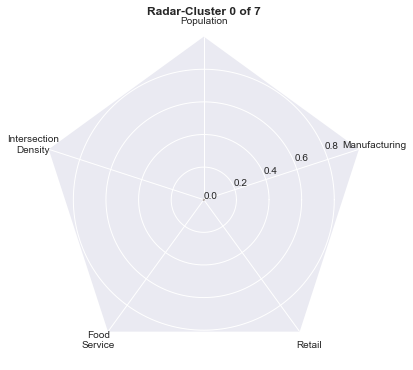

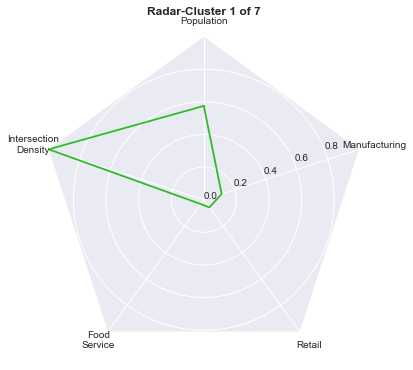

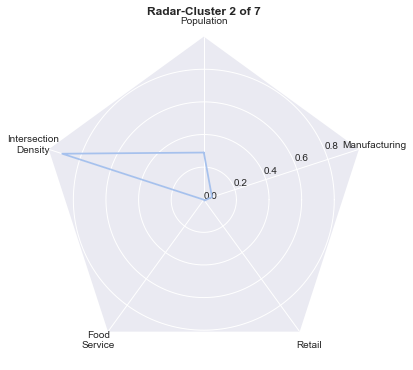

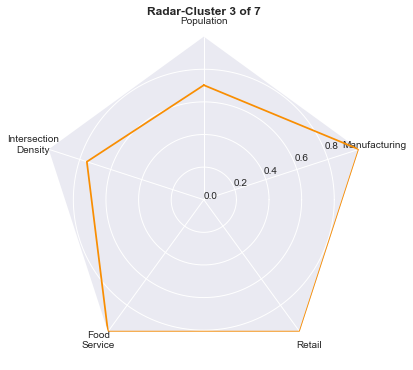

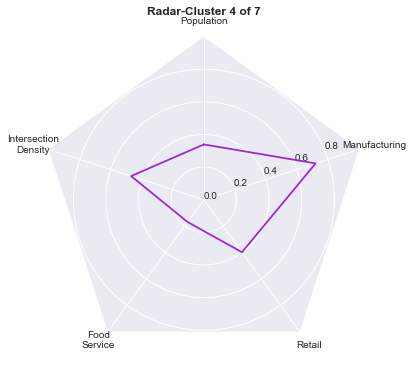

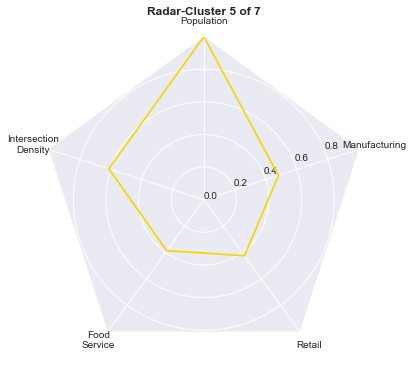

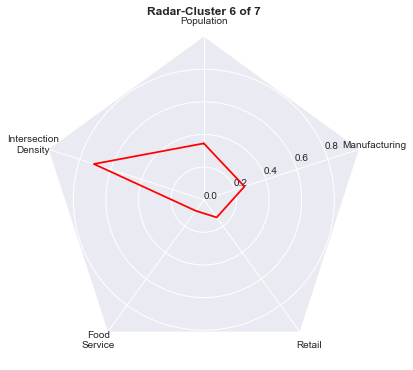

In [76]:
radar_chart(centroids, 'number_of_clusters', 'cluster_id',
            ['population','count_intersections',
             'N_Est_BFA','N_Est_RW','N_Est_Mfg'],
            ['Population','Intersection\nDensity',
             'Food\nService\n','Retail','Manufacturing'], city_name)

Adding the data frame the information regarding geo-coordinates.

In [67]:
pixels_data_filtered['index'] = pixels_data_filtered.index.tolist()
ClustersData = pd.merge(ClustersData, pixels_data_filtered[['index','lat','lon','utm_n','utm_e']],
                        how='left')

In [68]:
ClustersData

,index,population,count_intersections,streets_per_node_avg,betweenness_centrality_avg,primary_length_total_ext,highway_length_total_ext,fraction_oneway_ext,N_Est_Mfg,N_Est_BFA,N_Est_RW,N_Emp_Mfg,N_Emp_BFA,N_Emp_RW,N_Emp_Tot,POI_Count,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6,Prin7,kopt+0_Clusters,kopt+1_Clusters,kopt+2_Clusters,lat,lon,utm_n,utm_e
0,117,1461,114,3.041322,0.059484,0.000000,0.000000,0.164404,0.0,1.0,0.0,0.0,1.0,4.0,332.0,38,7.114727,1.648241,-0.716472,-1.662589,1.690011,1.488966,0.175915,2,5,5,-12.330026,-76.826524,8636276.063,301380.8033
1,248,3558,57,3.030769,0.096963,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,4.0,332.0,48,8.239472,-0.497781,4.218135,-3.305417,1.012448,0.217245,-0.444929,0,5,5,-12.311887,-76.835591,8638276.063,300380.8033
2,312,1768,63,3.260870,0.076863,0.000000,0.000000,0.061655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,8.235277,0.127473,0.727412,-1.628162,1.708633,2.378518,-1.185460,2,5,5,-12.302725,-76.853912,8639276.063,298380.8033
3,313,6137,96,3.140000,0.091784,0.000000,4060.184994,0.226727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,5.607381,-0.857567,-2.838239,-5.324318,-21.805404,8.777023,5.298749,6,6,8,-12.302787,-76.844720,8639276.063,299380.8033
4,378,8452,145,3.278912,0.060882,0.000000,0.000000,0.184630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,5.813062,4.105240,-2.443006,-1.055450,2.258324,2.950110,-1.207996,2,1,4,-12.293686,-76.853848,8640276.063,298380.8033
5,443,1416,23,3.521739,0.131752,0.000000,0.000000,0.351102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,7.220447,-0.976269,3.855626,-7.584883,1.314609,2.985858,-5.452076,0,5,5,-12.284586,-76.862976,8641276.063,297380.8033
6,444,1963,30,3.027778,0.118371,0.000000,0.000000,0.039808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9.778128,-2.953580,6.690823,-2.168602,0.573109,0.846566,0.330949,0,2,2,-12.284648,-76.853785,8641276.063,298380.8033
7,508,10039,66,3.185714,0.084119,0.000000,0.000000,0.452238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,5.160865,2.633752,2.603606,-5.491300,0.870054,2.333111,-2.635874,2,5,5,-12.275485,-76.872103,8642276.063,296380.8033
8,574,4149,9,2.200000,0.186813,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,13.047463,-8.727022,19.133299,-0.429795,-2.138990,-3.293593,7.022550,0,2,2,-12.266446,-76.872040,8643276.063,296380.8033
9,575,1870,42,2.722222,0.109391,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10.640185,-3.735674,8.036214,0.167269,0.042020,-0.175620,3.443778,0,2,2,-12.266509,-76.862849,8643276.063,297380.8033


Plotting results

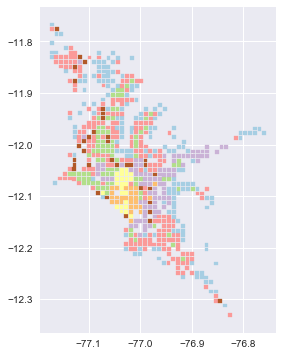

In [69]:
plot_map(ClustersData, 'kopt+0_Clusters')

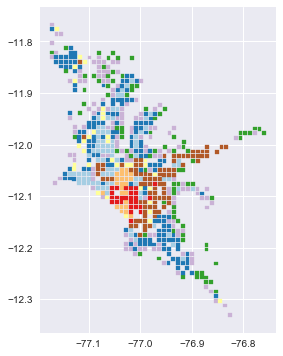

In [70]:
plot_map(ClustersData, 'kopt+1_Clusters')

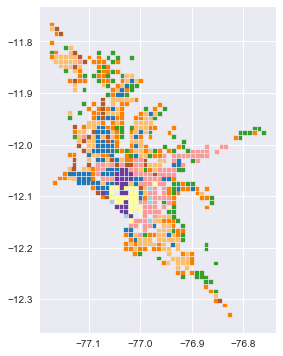

In [71]:
plot_map(ClustersData, 'kopt+2_Clusters')

Saving file

In [72]:
save_results(ClustersData, file_name='Output/'+city_name+'/'+city_name+'_ClustersData_withPOI.xlsx')
save_results(centroids, file_name='Output/'+city_name+'/'+city_name+'_Centroids_withPOI.xlsx')

End of code.